<a href="https://colab.research.google.com/github/ziatdinovmax/notebooks_for_medium/blob/main/DKL_for_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installation and data download 💽
!pip install -q git+https://github.com/pycroscopy/atomai.git
!gdown -q -O "dataset.npz" https://drive.google.com/uc?id=15vT1pKN9uiGIx0g0Ru4K8Stk4TIKizEc

In [2]:
#@title Imports 🔽
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import atomai as aoi
from shapely.geometry import Polygon

In [3]:
#@title Load helper functions  🛠️ { form-width: "20%" }

def make_window(imgsrc: np.ndarray, window_size: int,
                xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc


def create_training_set(hdata: np.ndarray, window_size: int,
                        slice: int = 0) -> Tuple[np.ndarray]:
    """
    Creates arrays with features (local subimages)
    and targets (corresponding spectra) from hyperspectral data
    """
    feature_arr, target_arr = [], []
    pos = []
    s1, s2 = hdata.shape[:-1]
    for i in range(s1):
        for j in range(s2):
            arr_loc = make_window(hdata[..., slice], window_size, i, j)
            if arr_loc.shape != (window_size, window_size):
                continue
            feature_arr.append(arr_loc)
            target_arr.append(hdata[i, j, :])
            pos.append([i, j])
    return np.array(pos), np.array(feature_arr), np.array(target_arr)

Load data into the notebook:

In [4]:
hdata, spec_val = np.load("dataset.npz").values()
print(hdata.shape, spec_val.shape)

(50, 50, 64) (64,)


Let's do some basic data inspection.

Plot averaged loop:

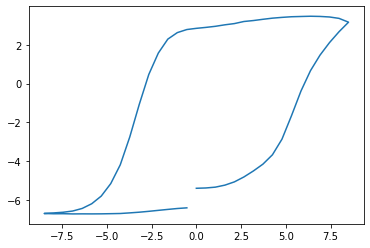

In [5]:
plt.plot(spec_val, hdata.mean(axis=(0,1)))
plt.show()

Plot structural 2D data which is a slice of hyperspectral data at V=0 (i.e., no applied voltage):

Text(0.5, 1.0, 'Structural data')

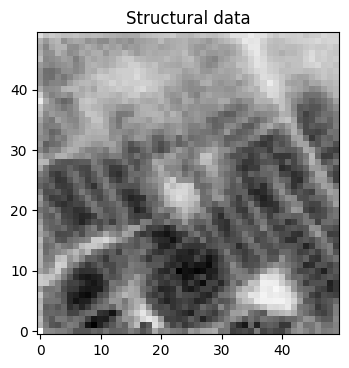

In [6]:
plt.figure(dpi=100)
plt.imshow(hdata[:, :, 0], origin="lower", interpolation="nearest", cmap='gray')
plt.title("Structural data")

## DKL

Create a stack of subimages (features) and the associated loops (targets):

In [7]:
wsize = 8 # window size for cropping 2D patches from a "mother" image 
pos_arr, feature_arr, target_arr = create_training_set(hdata, window_size=wsize)
feature_arr = feature_arr.reshape(feature_arr.shape[0], -1) # "flatten" image height and width
print(feature_arr.shape, target_arr.shape)

(1849, 64) (1849, 64)


Scalarize targets by compute loop areas:

In [8]:
polygons = []
for val1 in target_arr:
    polygon = []
    for i, v in enumerate(spec_val):
        polygon.append([v, val1[i]])
    polygons.append(polygon)
target_area = np.array([Polygon(p).area for p in polygons])
print(target_area.shape)

(1849,)


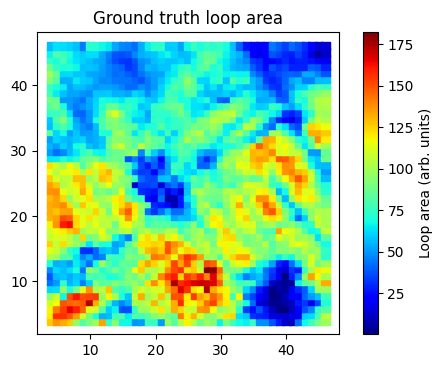

In [9]:
_, ax = plt.subplots(dpi=100)
l = ax.scatter(pos_arr[:, 1], pos_arr[:, 0], c=target_area, cmap='jet', marker='s')
ax.set_aspect('equal')
ax.set_title("Ground truth loop area")
plt.colorbar(l, label="Loop area (arb. units)")

Prepare the data. Here the ```X_train``` and ```y_train``` are our measured image patches (structure) and spectral targets (loop area), whereas the ```X_test``` and ```y_test``` are the "unknown" ones. The ```indices_train``` are grid coordinates of the measured points, whereas the ```indices_test``` are the grid coordinates of the remaining available points on the grid.

In [10]:
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      feature_arr, target_area, pos_arr, test_size=0.998, shuffle=True, random_state=1)

Run DKL-based search for structural regions that maximize loop area:

(one thing to keep in mind is that this search will run *much* faster on modern GPUs such as Nvidia's V100 and A100)

1/25


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 1/500 ... Training loss: 4565.5576
Epoch 10/500 ... Training loss: 4105.8213
Epoch 20/500 ... Training loss: 3630.2107
Epoch 30/500 ... Training loss: 3258.1277
Epoch 40/500 ... Training loss: 2952.0146
Epoch 50/500 ... Training loss: 2698.4663
Epoch 60/500 ... Training loss: 2481.4678
Epoch 70/500 ... Training loss: 2299.4028
Epoch 80/500 ... Training loss: 2143.3564
Epoch 90/500 ... Training loss: 2004.2812
Epoch 100/500 ... Training loss: 1877.5066
Epoch 110/500 ... Training loss: 1772.958
Epoch 120/500 ... Training loss: 1672.2324
Epoch 130/500 ... Training loss: 1586.0728
Epoch 140/500 ... Training loss: 1506.5795
Epoch 150/500 ... Training loss: 1435.5342
Epoch 160/500 ... Training loss: 1369.2666
Epoch 170/500 ... Training loss: 1309.8636
Epoch 180/500 ... Training loss: 1255.9553
Epoch 190/500 ... Training loss: 1205.0409
Epoch 200/500 ... Training loss: 1158.8821
Epoch 210/500 ... Training loss: 1116.2659
Epoch 220/500 ... Training loss: 1076.8816
Epoch 230/500 ... Train

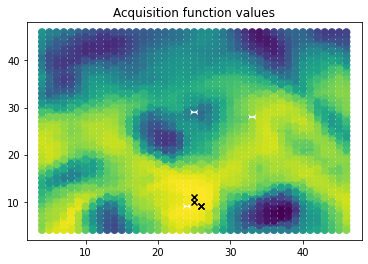

2/25
Epoch 1/500 ... Training loss: 2794.8362


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 2388.7322
Epoch 20/500 ... Training loss: 2120.7207
Epoch 30/500 ... Training loss: 1891.384
Epoch 40/500 ... Training loss: 1701.1011
Epoch 50/500 ... Training loss: 1546.5535
Epoch 60/500 ... Training loss: 1417.3206
Epoch 70/500 ... Training loss: 1308.6863
Epoch 80/500 ... Training loss: 1214.146
Epoch 90/500 ... Training loss: 1131.5183
Epoch 100/500 ... Training loss: 1059.955
Epoch 110/500 ... Training loss: 996.1011
Epoch 120/500 ... Training loss: 940.2952
Epoch 130/500 ... Training loss: 890.4175
Epoch 140/500 ... Training loss: 847.5156
Epoch 150/500 ... Training loss: 805.2731
Epoch 160/500 ... Training loss: 768.7546
Epoch 170/500 ... Training loss: 734.8218
Epoch 180/500 ... Training loss: 703.719
Epoch 190/500 ... Training loss: 674.8642
Epoch 200/500 ... Training loss: 655.3481
Epoch 210/500 ... Training loss: 625.9126
Epoch 220/500 ... Training loss: 603.4109
Epoch 230/500 ... Training loss: 594.8217
Epoch 240/500 ... Training loss: 562.

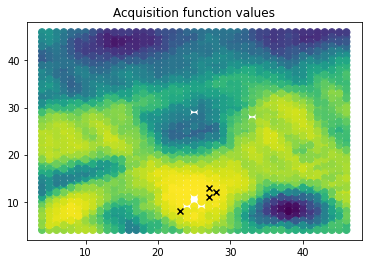

3/25
Epoch 1/500 ... Training loss: 2265.9092


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 1905.4274
Epoch 20/500 ... Training loss: 1689.1486
Epoch 30/500 ... Training loss: 1508.348
Epoch 40/500 ... Training loss: 1369.4351
Epoch 50/500 ... Training loss: 1245.255
Epoch 60/500 ... Training loss: 1144.4504
Epoch 70/500 ... Training loss: 1055.4989
Epoch 80/500 ... Training loss: 987.6274
Epoch 90/500 ... Training loss: 907.2314
Epoch 100/500 ... Training loss: 847.3965
Epoch 110/500 ... Training loss: 802.7092
Epoch 120/500 ... Training loss: 767.7051
Epoch 130/500 ... Training loss: 722.2115
Epoch 140/500 ... Training loss: 679.2285
Epoch 150/500 ... Training loss: 644.7285
Epoch 160/500 ... Training loss: 611.8146
Epoch 170/500 ... Training loss: 578.595
Epoch 180/500 ... Training loss: 543.9988
Epoch 190/500 ... Training loss: 528.1794
Epoch 200/500 ... Training loss: 507.3215
Epoch 210/500 ... Training loss: 485.35
Epoch 220/500 ... Training loss: 458.1716
Epoch 230/500 ... Training loss: 441.1154
Epoch 240/500 ... Training loss: 425.2712

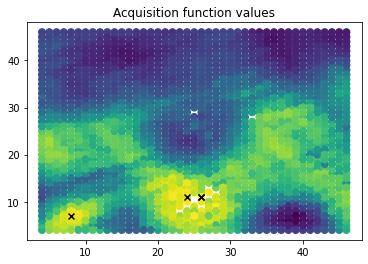

4/25
Epoch 1/500 ... Training loss: 1718.7444


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 1440.5176
Epoch 20/500 ... Training loss: 1272.0537
Epoch 30/500 ... Training loss: 1124.7373
Epoch 40/500 ... Training loss: 1023.7445
Epoch 50/500 ... Training loss: 926.3425
Epoch 60/500 ... Training loss: 840.5965
Epoch 70/500 ... Training loss: 777.7848
Epoch 80/500 ... Training loss: 722.2915
Epoch 90/500 ... Training loss: 673.8558
Epoch 100/500 ... Training loss: 631.058
Epoch 110/500 ... Training loss: 590.4828
Epoch 120/500 ... Training loss: 554.9725
Epoch 130/500 ... Training loss: 528.7313
Epoch 140/500 ... Training loss: 499.3915
Epoch 150/500 ... Training loss: 471.2127
Epoch 160/500 ... Training loss: 437.3765
Epoch 170/500 ... Training loss: 416.6098
Epoch 180/500 ... Training loss: 397.8969
Epoch 190/500 ... Training loss: 381.0008
Epoch 200/500 ... Training loss: 366.0644
Epoch 210/500 ... Training loss: 352.3079
Epoch 220/500 ... Training loss: 339.6266
Epoch 230/500 ... Training loss: 327.8658
Epoch 240/500 ... Training loss: 316.926

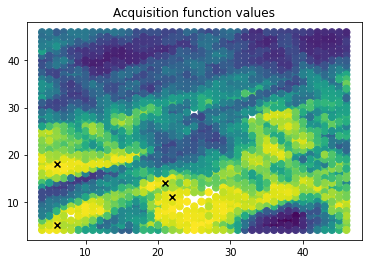

5/25
Epoch 1/500 ... Training loss: 1440.6372


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 1183.797
Epoch 20/500 ... Training loss: 1034.0542
Epoch 30/500 ... Training loss: 928.5966
Epoch 40/500 ... Training loss: 840.5157
Epoch 50/500 ... Training loss: 764.1036
Epoch 60/500 ... Training loss: 693.2743
Epoch 70/500 ... Training loss: 630.6208
Epoch 80/500 ... Training loss: 573.6017
Epoch 90/500 ... Training loss: 520.7886
Epoch 100/500 ... Training loss: 482.3151
Epoch 110/500 ... Training loss: 449.1218
Epoch 120/500 ... Training loss: 418.2023
Epoch 130/500 ... Training loss: 392.9069
Epoch 140/500 ... Training loss: 370.9741
Epoch 150/500 ... Training loss: 352.0562
Epoch 160/500 ... Training loss: 335.1213
Epoch 170/500 ... Training loss: 319.7254
Epoch 180/500 ... Training loss: 305.526
Epoch 190/500 ... Training loss: 292.6086
Epoch 200/500 ... Training loss: 280.873
Epoch 210/500 ... Training loss: 270.0691
Epoch 220/500 ... Training loss: 260.0718
Epoch 230/500 ... Training loss: 250.813
Epoch 240/500 ... Training loss: 242.2305
Epo

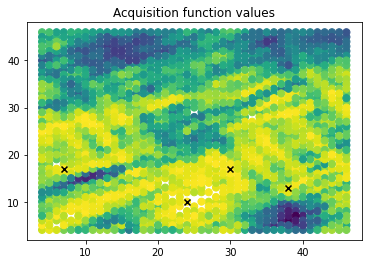

6/25
Epoch 1/500 ... Training loss: 1299.0845


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 1075.3835
Epoch 20/500 ... Training loss: 928.7548
Epoch 30/500 ... Training loss: 806.5972
Epoch 40/500 ... Training loss: 706.929
Epoch 50/500 ... Training loss: 626.6523
Epoch 60/500 ... Training loss: 554.9658
Epoch 70/500 ... Training loss: 511.9101
Epoch 80/500 ... Training loss: 460.9303
Epoch 90/500 ... Training loss: 423.3682
Epoch 100/500 ... Training loss: 391.3604
Epoch 110/500 ... Training loss: 365.5032
Epoch 120/500 ... Training loss: 343.5757
Epoch 130/500 ... Training loss: 324.3334
Epoch 140/500 ... Training loss: 307.1815
Epoch 150/500 ... Training loss: 291.7476
Epoch 160/500 ... Training loss: 277.7744
Epoch 170/500 ... Training loss: 265.0912
Epoch 180/500 ... Training loss: 253.5503
Epoch 190/500 ... Training loss: 243.0104
Epoch 200/500 ... Training loss: 233.3464
Epoch 210/500 ... Training loss: 224.4543
Epoch 220/500 ... Training loss: 216.2417
Epoch 230/500 ... Training loss: 208.6274
Epoch 240/500 ... Training loss: 201.5408
E

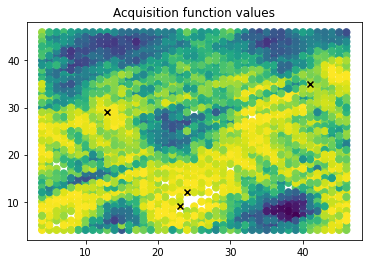

7/25
Epoch 1/500 ... Training loss: 1364.2018


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 971.7288
Epoch 20/500 ... Training loss: 815.167
Epoch 30/500 ... Training loss: 697.9514
Epoch 40/500 ... Training loss: 605.8701
Epoch 50/500 ... Training loss: 535.1744
Epoch 60/500 ... Training loss: 478.3348
Epoch 70/500 ... Training loss: 428.968
Epoch 80/500 ... Training loss: 392.5771
Epoch 90/500 ... Training loss: 363.9132
Epoch 100/500 ... Training loss: 339.0743
Epoch 110/500 ... Training loss: 317.254
Epoch 120/500 ... Training loss: 297.8819
Epoch 130/500 ... Training loss: 281.2712
Epoch 140/500 ... Training loss: 266.4476
Epoch 150/500 ... Training loss: 253.112
Epoch 160/500 ... Training loss: 242.9939
Epoch 170/500 ... Training loss: 254.9268
Epoch 180/500 ... Training loss: 239.6949
Epoch 190/500 ... Training loss: 222.1609
Epoch 200/500 ... Training loss: 207.5494
Epoch 210/500 ... Training loss: 196.5529
Epoch 220/500 ... Training loss: 188.593
Epoch 230/500 ... Training loss: 181.7422
Epoch 240/500 ... Training loss: 175.4897
Epoch 

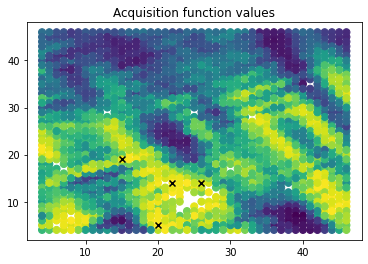

8/25
Epoch 1/500 ... Training loss: 1189.8091


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 896.3856
Epoch 20/500 ... Training loss: 754.8398
Epoch 30/500 ... Training loss: 646.1979
Epoch 40/500 ... Training loss: 555.8109
Epoch 50/500 ... Training loss: 482.1064
Epoch 60/500 ... Training loss: 425.2316
Epoch 70/500 ... Training loss: 379.1893
Epoch 80/500 ... Training loss: 344.9752
Epoch 90/500 ... Training loss: 317.4103
Epoch 100/500 ... Training loss: 297.0142
Epoch 110/500 ... Training loss: 282.9139
Epoch 120/500 ... Training loss: 269.6285
Epoch 130/500 ... Training loss: 250.1023
Epoch 140/500 ... Training loss: 235.4681
Epoch 150/500 ... Training loss: 226.2468
Epoch 160/500 ... Training loss: 219.516
Epoch 170/500 ... Training loss: 205.8975
Epoch 180/500 ... Training loss: 213.5363
Epoch 190/500 ... Training loss: 192.2666
Epoch 200/500 ... Training loss: 181.5394
Epoch 210/500 ... Training loss: 173.7782
Epoch 220/500 ... Training loss: 167.0195
Epoch 230/500 ... Training loss: 161.1204
Epoch 240/500 ... Training loss: 155.6729
Ep

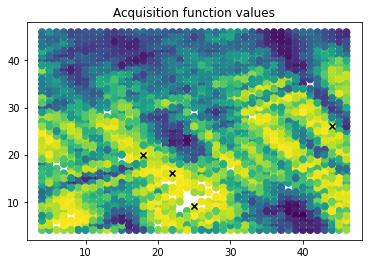

9/25
Epoch 1/500 ... Training loss: 1097.7695


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 803.1976
Epoch 20/500 ... Training loss: 685.4385
Epoch 30/500 ... Training loss: 588.3262
Epoch 40/500 ... Training loss: 504.5391
Epoch 50/500 ... Training loss: 429.7437
Epoch 60/500 ... Training loss: 376.5998
Epoch 70/500 ... Training loss: 339.5096
Epoch 80/500 ... Training loss: 307.55
Epoch 90/500 ... Training loss: 283.638
Epoch 100/500 ... Training loss: 263.6704
Epoch 110/500 ... Training loss: 247.1974
Epoch 120/500 ... Training loss: 232.7696
Epoch 130/500 ... Training loss: 221.8169
Epoch 140/500 ... Training loss: 210.2771
Epoch 150/500 ... Training loss: 198.6876
Epoch 160/500 ... Training loss: 189.5251
Epoch 170/500 ... Training loss: 180.6906
Epoch 180/500 ... Training loss: 172.8895
Epoch 190/500 ... Training loss: 165.8612
Epoch 200/500 ... Training loss: 159.4252
Epoch 210/500 ... Training loss: 153.3282
Epoch 220/500 ... Training loss: 147.6293
Epoch 230/500 ... Training loss: 142.2236
Epoch 240/500 ... Training loss: 137.4102
Epoc

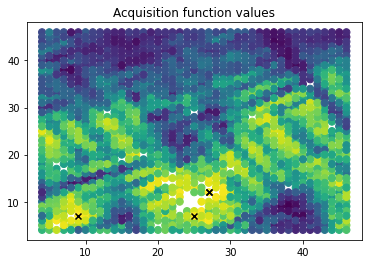

10/25
Epoch 1/500 ... Training loss: 1011.5917


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 750.8582
Epoch 20/500 ... Training loss: 644.4969
Epoch 30/500 ... Training loss: 554.382
Epoch 40/500 ... Training loss: 477.7332
Epoch 50/500 ... Training loss: 410.1398
Epoch 60/500 ... Training loss: 375.2238
Epoch 70/500 ... Training loss: 341.5013
Epoch 80/500 ... Training loss: 290.3541
Epoch 90/500 ... Training loss: 259.7376
Epoch 100/500 ... Training loss: 238.9487
Epoch 110/500 ... Training loss: 221.8602
Epoch 120/500 ... Training loss: 208.2943
Epoch 130/500 ... Training loss: 196.3714
Epoch 140/500 ... Training loss: 185.9064
Epoch 150/500 ... Training loss: 176.6238
Epoch 160/500 ... Training loss: 168.2234
Epoch 170/500 ... Training loss: 160.6099
Epoch 180/500 ... Training loss: 153.6696
Epoch 190/500 ... Training loss: 147.3673
Epoch 200/500 ... Training loss: 141.5146
Epoch 210/500 ... Training loss: 136.1627
Epoch 220/500 ... Training loss: 131.1908
Epoch 230/500 ... Training loss: 126.5628
Epoch 240/500 ... Training loss: 122.4134
Ep

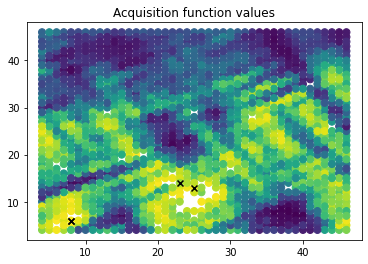

11/25
Epoch 1/500 ... Training loss: 957.8248


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 710.246
Epoch 20/500 ... Training loss: 608.1194
Epoch 30/500 ... Training loss: 518.2236
Epoch 40/500 ... Training loss: 442.4235
Epoch 50/500 ... Training loss: 375.628
Epoch 60/500 ... Training loss: 330.3499
Epoch 70/500 ... Training loss: 312.6788
Epoch 80/500 ... Training loss: 272.9409
Epoch 90/500 ... Training loss: 243.5812
Epoch 100/500 ... Training loss: 219.0739
Epoch 110/500 ... Training loss: 203.8303
Epoch 120/500 ... Training loss: 191.1874
Epoch 130/500 ... Training loss: 180.3049
Epoch 140/500 ... Training loss: 170.656
Epoch 150/500 ... Training loss: 162.3195
Epoch 160/500 ... Training loss: 154.286
Epoch 170/500 ... Training loss: 147.2704
Epoch 180/500 ... Training loss: 140.9062
Epoch 190/500 ... Training loss: 135.0707
Epoch 200/500 ... Training loss: 129.8446
Epoch 210/500 ... Training loss: 124.9365
Epoch 220/500 ... Training loss: 120.348
Epoch 230/500 ... Training loss: 116.125
Epoch 240/500 ... Training loss: 112.2306
Epoch 2

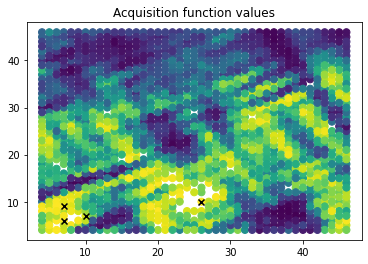

12/25
Epoch 1/500 ... Training loss: 979.3776


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 760.79
Epoch 20/500 ... Training loss: 650.3043
Epoch 30/500 ... Training loss: 560.2051
Epoch 40/500 ... Training loss: 472.6044
Epoch 50/500 ... Training loss: 393.8834
Epoch 60/500 ... Training loss: 323.7806
Epoch 70/500 ... Training loss: 269.613
Epoch 80/500 ... Training loss: 241.67
Epoch 90/500 ... Training loss: 221.6104
Epoch 100/500 ... Training loss: 206.3191
Epoch 110/500 ... Training loss: 192.8692
Epoch 120/500 ... Training loss: 181.2958
Epoch 130/500 ... Training loss: 171.2905
Epoch 140/500 ... Training loss: 162.1412
Epoch 150/500 ... Training loss: 153.8791
Epoch 160/500 ... Training loss: 146.7858
Epoch 170/500 ... Training loss: 142.6327
Epoch 180/500 ... Training loss: 138.8009
Epoch 190/500 ... Training loss: 129.2686
Epoch 200/500 ... Training loss: 123.9023
Epoch 210/500 ... Training loss: 119.2109
Epoch 220/500 ... Training loss: 114.9428
Epoch 230/500 ... Training loss: 110.8986
Epoch 240/500 ... Training loss: 106.946
Epoch 2

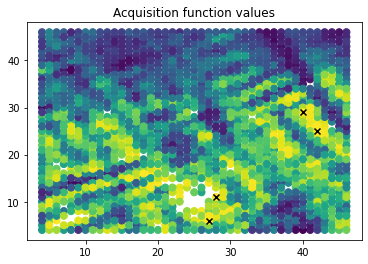

13/25
Epoch 1/500 ... Training loss: 908.665


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 699.4895
Epoch 20/500 ... Training loss: 599.2654
Epoch 30/500 ... Training loss: 518.7866
Epoch 40/500 ... Training loss: 447.4716
Epoch 50/500 ... Training loss: 364.3769
Epoch 60/500 ... Training loss: 307.9345
Epoch 70/500 ... Training loss: 268.9388
Epoch 80/500 ... Training loss: 233.8347
Epoch 90/500 ... Training loss: 222.8291
Epoch 100/500 ... Training loss: 201.4814
Epoch 110/500 ... Training loss: 183.9749
Epoch 120/500 ... Training loss: 172.6245
Epoch 130/500 ... Training loss: 165.2034
Epoch 140/500 ... Training loss: 170.3192
Epoch 150/500 ... Training loss: 146.4491
Epoch 160/500 ... Training loss: 139.3909
Epoch 170/500 ... Training loss: 131.7254
Epoch 180/500 ... Training loss: 125.2251
Epoch 190/500 ... Training loss: 119.8105
Epoch 200/500 ... Training loss: 114.9101
Epoch 210/500 ... Training loss: 110.4264
Epoch 220/500 ... Training loss: 106.322
Epoch 230/500 ... Training loss: 102.542
Epoch 240/500 ... Training loss: 99.0411
Epoc

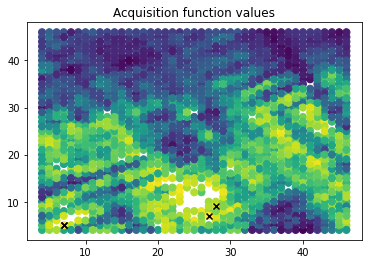

14/25
Epoch 1/500 ... Training loss: 869.3851


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 684.9185
Epoch 20/500 ... Training loss: 581.8037
Epoch 30/500 ... Training loss: 500.1699
Epoch 40/500 ... Training loss: 429.707
Epoch 50/500 ... Training loss: 332.8042
Epoch 60/500 ... Training loss: 269.2313
Epoch 70/500 ... Training loss: 236.2142
Epoch 80/500 ... Training loss: 213.0048
Epoch 90/500 ... Training loss: 195.8154
Epoch 100/500 ... Training loss: 182.3658
Epoch 110/500 ... Training loss: 178.7728
Epoch 120/500 ... Training loss: 161.9585
Epoch 130/500 ... Training loss: 173.0421
Epoch 140/500 ... Training loss: 160.8587
Epoch 150/500 ... Training loss: 139.8864
Epoch 160/500 ... Training loss: 132.6797
Epoch 170/500 ... Training loss: 125.3062
Epoch 180/500 ... Training loss: 119.5081
Epoch 190/500 ... Training loss: 114.1029
Epoch 200/500 ... Training loss: 109.8826
Epoch 210/500 ... Training loss: 105.324
Epoch 220/500 ... Training loss: 101.5764
Epoch 230/500 ... Training loss: 98.1961
Epoch 240/500 ... Training loss: 94.7151
Epoch

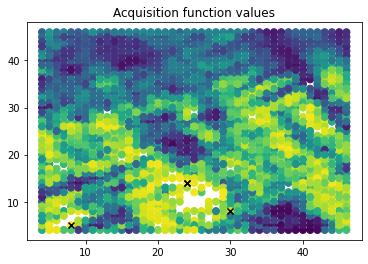

15/25
Epoch 1/500 ... Training loss: 817.55


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 612.0665
Epoch 20/500 ... Training loss: 522.1414
Epoch 30/500 ... Training loss: 459.4651
Epoch 40/500 ... Training loss: 402.4691
Epoch 50/500 ... Training loss: 335.1761
Epoch 60/500 ... Training loss: 271.91
Epoch 70/500 ... Training loss: 246.1825
Epoch 80/500 ... Training loss: 213.5855
Epoch 90/500 ... Training loss: 191.0353
Epoch 100/500 ... Training loss: 176.4735
Epoch 110/500 ... Training loss: 166.0551
Epoch 120/500 ... Training loss: 154.794
Epoch 130/500 ... Training loss: 145.5518
Epoch 140/500 ... Training loss: 137.5974
Epoch 150/500 ... Training loss: 130.1109
Epoch 160/500 ... Training loss: 123.3528
Epoch 170/500 ... Training loss: 117.7002
Epoch 180/500 ... Training loss: 112.9107
Epoch 190/500 ... Training loss: 109.0589
Epoch 200/500 ... Training loss: 103.5278
Epoch 210/500 ... Training loss: 98.9238
Epoch 220/500 ... Training loss: 95.36
Epoch 230/500 ... Training loss: 91.9863
Epoch 240/500 ... Training loss: 88.3855
Epoch 250/

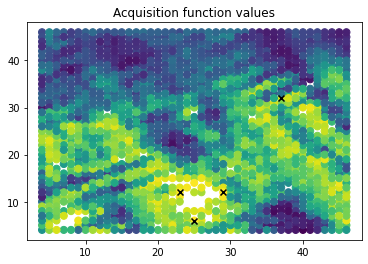

16/25
Epoch 1/500 ... Training loss: 805.4005


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 597.64
Epoch 20/500 ... Training loss: 510.9203
Epoch 30/500 ... Training loss: 438.842
Epoch 40/500 ... Training loss: 366.3595
Epoch 50/500 ... Training loss: 297.2565
Epoch 60/500 ... Training loss: 247.9164
Epoch 70/500 ... Training loss: 219.4573
Epoch 80/500 ... Training loss: 205.4598
Epoch 90/500 ... Training loss: 185.3636
Epoch 100/500 ... Training loss: 167.9394
Epoch 110/500 ... Training loss: 157.3654
Epoch 120/500 ... Training loss: 146.71
Epoch 130/500 ... Training loss: 137.9477
Epoch 140/500 ... Training loss: 130.1622
Epoch 150/500 ... Training loss: 125.2615
Epoch 160/500 ... Training loss: 117.7294
Epoch 170/500 ... Training loss: 112.0875
Epoch 180/500 ... Training loss: 107.2607
Epoch 190/500 ... Training loss: 102.3533
Epoch 200/500 ... Training loss: 97.7164
Epoch 210/500 ... Training loss: 94.4837
Epoch 220/500 ... Training loss: 90.1763
Epoch 230/500 ... Training loss: 87.0561
Epoch 240/500 ... Training loss: 84.5219
Epoch 250/5

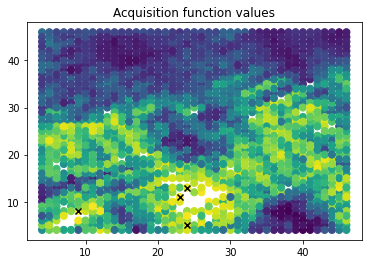

17/25
Epoch 1/500 ... Training loss: 769.4131


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 568.9999
Epoch 20/500 ... Training loss: 486.0214
Epoch 30/500 ... Training loss: 417.2873
Epoch 40/500 ... Training loss: 343.8219
Epoch 50/500 ... Training loss: 294.2412
Epoch 60/500 ... Training loss: 261.259
Epoch 70/500 ... Training loss: 229.3383
Epoch 80/500 ... Training loss: 219.5475
Epoch 90/500 ... Training loss: 194.8125
Epoch 100/500 ... Training loss: 168.5856
Epoch 110/500 ... Training loss: 153.484
Epoch 120/500 ... Training loss: 142.762
Epoch 130/500 ... Training loss: 134.1718
Epoch 140/500 ... Training loss: 126.5363
Epoch 150/500 ... Training loss: 119.7778
Epoch 160/500 ... Training loss: 115.6529
Epoch 170/500 ... Training loss: 109.8379
Epoch 180/500 ... Training loss: 103.5652
Epoch 190/500 ... Training loss: 97.7073
Epoch 200/500 ... Training loss: 93.2274
Epoch 210/500 ... Training loss: 89.3129
Epoch 220/500 ... Training loss: 85.8113
Epoch 230/500 ... Training loss: 82.5738
Epoch 240/500 ... Training loss: 79.7717
Epoch 250/

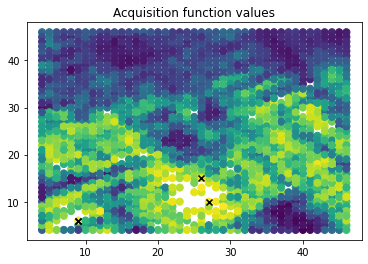

18/25
Epoch 1/500 ... Training loss: 738.772


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 547.7131
Epoch 20/500 ... Training loss: 468.7101
Epoch 30/500 ... Training loss: 403.8466
Epoch 40/500 ... Training loss: 338.6254
Epoch 50/500 ... Training loss: 268.9745
Epoch 60/500 ... Training loss: 229.0601
Epoch 70/500 ... Training loss: 198.9758
Epoch 80/500 ... Training loss: 199.35
Epoch 90/500 ... Training loss: 175.1688
Epoch 100/500 ... Training loss: 155.3676
Epoch 110/500 ... Training loss: 145.3858
Epoch 120/500 ... Training loss: 134.6962
Epoch 130/500 ... Training loss: 126.1647
Epoch 140/500 ... Training loss: 120.0774
Epoch 150/500 ... Training loss: 113.0949
Epoch 160/500 ... Training loss: 107.1699
Epoch 170/500 ... Training loss: 101.5493
Epoch 180/500 ... Training loss: 97.2341
Epoch 190/500 ... Training loss: 92.69
Epoch 200/500 ... Training loss: 89.6694
Epoch 210/500 ... Training loss: 85.59
Epoch 220/500 ... Training loss: 81.9074
Epoch 230/500 ... Training loss: 78.7426
Epoch 240/500 ... Training loss: 75.8024
Epoch 250/500 

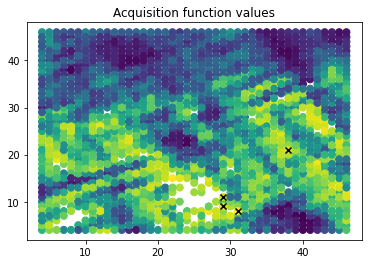

19/25
Epoch 1/500 ... Training loss: 714.3593


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 544.2107
Epoch 20/500 ... Training loss: 466.6277
Epoch 30/500 ... Training loss: 400.7563
Epoch 40/500 ... Training loss: 340.2174
Epoch 50/500 ... Training loss: 275.6003
Epoch 60/500 ... Training loss: 219.9863
Epoch 70/500 ... Training loss: 196.7375
Epoch 80/500 ... Training loss: 173.3212
Epoch 90/500 ... Training loss: 156.7202
Epoch 100/500 ... Training loss: 147.1173
Epoch 110/500 ... Training loss: 135.4359
Epoch 120/500 ... Training loss: 127.0612
Epoch 130/500 ... Training loss: 119.283
Epoch 140/500 ... Training loss: 112.8357
Epoch 150/500 ... Training loss: 106.8369
Epoch 160/500 ... Training loss: 101.0068
Epoch 170/500 ... Training loss: 95.8546
Epoch 180/500 ... Training loss: 91.9185
Epoch 190/500 ... Training loss: 88.6272
Epoch 200/500 ... Training loss: 87.1568
Epoch 210/500 ... Training loss: 83.9122
Epoch 220/500 ... Training loss: 79.3352
Epoch 230/500 ... Training loss: 75.698
Epoch 240/500 ... Training loss: 73.6736
Epoch 250/5

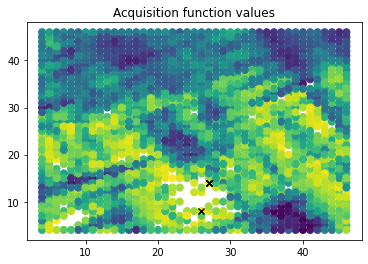

20/25


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 1/500 ... Training loss: 681.6243
Epoch 10/500 ... Training loss: 506.2207
Epoch 20/500 ... Training loss: 435.3287
Epoch 30/500 ... Training loss: 375.837
Epoch 40/500 ... Training loss: 320.1563
Epoch 50/500 ... Training loss: 262.1536
Epoch 60/500 ... Training loss: 225.9716
Epoch 70/500 ... Training loss: 191.9201
Epoch 80/500 ... Training loss: 170.7343
Epoch 90/500 ... Training loss: 154.1712
Epoch 100/500 ... Training loss: 142.8239
Epoch 110/500 ... Training loss: 132.8549
Epoch 120/500 ... Training loss: 123.481
Epoch 130/500 ... Training loss: 115.5081
Epoch 140/500 ... Training loss: 108.0065
Epoch 150/500 ... Training loss: 102.2277
Epoch 160/500 ... Training loss: 97.7828
Epoch 170/500 ... Training loss: 92.5509
Epoch 180/500 ... Training loss: 88.8311
Epoch 190/500 ... Training loss: 84.5026
Epoch 200/500 ... Training loss: 80.1155
Epoch 210/500 ... Training loss: 77.1603
Epoch 220/500 ... Training loss: 73.6608
Epoch 230/500 ... Training loss: 71.5301
Epoch 240/500

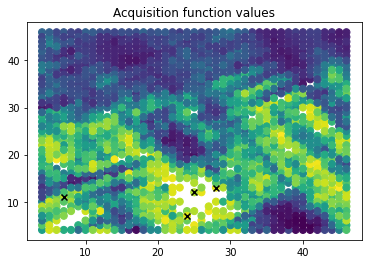

21/25
Epoch 1/500 ... Training loss: 683.5063


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 513.8943
Epoch 20/500 ... Training loss: 439.8338
Epoch 30/500 ... Training loss: 385.1707
Epoch 40/500 ... Training loss: 334.377
Epoch 50/500 ... Training loss: 278.7377
Epoch 60/500 ... Training loss: 226.1903
Epoch 70/500 ... Training loss: 212.5896
Epoch 80/500 ... Training loss: 167.9293
Epoch 90/500 ... Training loss: 156.1156
Epoch 100/500 ... Training loss: 164.2747
Epoch 110/500 ... Training loss: 150.4551
Epoch 120/500 ... Training loss: 135.1165
Epoch 130/500 ... Training loss: 116.8674
Epoch 140/500 ... Training loss: 105.9746
Epoch 150/500 ... Training loss: 98.6558
Epoch 160/500 ... Training loss: 93.3856
Epoch 170/500 ... Training loss: 88.7032
Epoch 180/500 ... Training loss: 84.8215
Epoch 190/500 ... Training loss: 81.1275
Epoch 200/500 ... Training loss: 77.9677
Epoch 210/500 ... Training loss: 74.848
Epoch 220/500 ... Training loss: 71.9831
Epoch 230/500 ... Training loss: 69.3783
Epoch 240/500 ... Training loss: 67.4652
Epoch 250/500

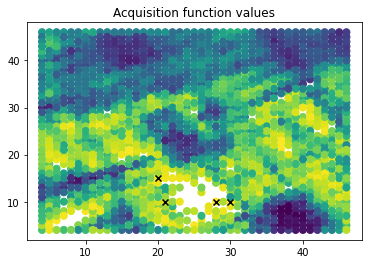

22/25
Epoch 1/500 ... Training loss: 662.5148


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 494.1122
Epoch 20/500 ... Training loss: 423.7537
Epoch 30/500 ... Training loss: 372.6823
Epoch 40/500 ... Training loss: 325.5308
Epoch 50/500 ... Training loss: 274.1119
Epoch 60/500 ... Training loss: 217.0303
Epoch 70/500 ... Training loss: 183.7292
Epoch 80/500 ... Training loss: 155.0436
Epoch 90/500 ... Training loss: 138.5871
Epoch 100/500 ... Training loss: 132.6071
Epoch 110/500 ... Training loss: 120.798
Epoch 120/500 ... Training loss: 112.0145
Epoch 130/500 ... Training loss: 103.928
Epoch 140/500 ... Training loss: 99.1896
Epoch 150/500 ... Training loss: 97.5444
Epoch 160/500 ... Training loss: 102.7999
Epoch 170/500 ... Training loss: 93.1106
Epoch 180/500 ... Training loss: 84.143
Epoch 190/500 ... Training loss: 81.3739
Epoch 200/500 ... Training loss: 86.928
Epoch 210/500 ... Training loss: 74.4957
Epoch 220/500 ... Training loss: 69.6925
Epoch 230/500 ... Training loss: 66.8929
Epoch 240/500 ... Training loss: 64.4818
Epoch 250/500 .

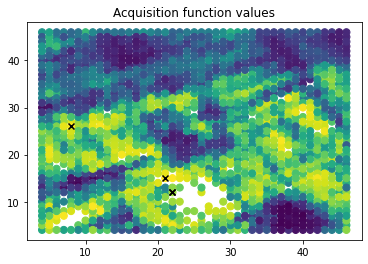

23/25
Epoch 1/500 ... Training loss: 635.7285


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 474.1411
Epoch 20/500 ... Training loss: 406.3342
Epoch 30/500 ... Training loss: 354.3659
Epoch 40/500 ... Training loss: 304.1345
Epoch 50/500 ... Training loss: 247.4059
Epoch 60/500 ... Training loss: 206.6307
Epoch 70/500 ... Training loss: 190.1219
Epoch 80/500 ... Training loss: 161.369
Epoch 90/500 ... Training loss: 141.1002
Epoch 100/500 ... Training loss: 127.6226
Epoch 110/500 ... Training loss: 117.102
Epoch 120/500 ... Training loss: 108.8816
Epoch 130/500 ... Training loss: 101.8688
Epoch 140/500 ... Training loss: 95.7804
Epoch 150/500 ... Training loss: 90.4595
Epoch 160/500 ... Training loss: 85.9095
Epoch 170/500 ... Training loss: 81.6855
Epoch 180/500 ... Training loss: 78.2623
Epoch 190/500 ... Training loss: 74.8568
Epoch 200/500 ... Training loss: 72.6633
Epoch 210/500 ... Training loss: 70.5856
Epoch 220/500 ... Training loss: 65.7355
Epoch 230/500 ... Training loss: 63.128
Epoch 240/500 ... Training loss: 61.2768
Epoch 250/500 .

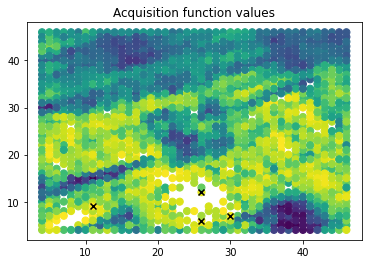

24/25
Epoch 1/500 ... Training loss: 627.2759


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 470.7075
Epoch 20/500 ... Training loss: 402.8232
Epoch 30/500 ... Training loss: 346.9792
Epoch 40/500 ... Training loss: 297.6671
Epoch 50/500 ... Training loss: 241.1405
Epoch 60/500 ... Training loss: 206.2239
Epoch 70/500 ... Training loss: 173.7495
Epoch 80/500 ... Training loss: 164.6241
Epoch 90/500 ... Training loss: 139.8838
Epoch 100/500 ... Training loss: 127.6242
Epoch 110/500 ... Training loss: 115.9285
Epoch 120/500 ... Training loss: 105.2728
Epoch 130/500 ... Training loss: 101.9232
Epoch 140/500 ... Training loss: 91.9145
Epoch 150/500 ... Training loss: 86.5797
Epoch 160/500 ... Training loss: 82.0027
Epoch 170/500 ... Training loss: 77.8986
Epoch 180/500 ... Training loss: 74.1328
Epoch 190/500 ... Training loss: 70.8001
Epoch 200/500 ... Training loss: 68.2195
Epoch 210/500 ... Training loss: 65.9357
Epoch 220/500 ... Training loss: 63.1759
Epoch 230/500 ... Training loss: 61.094
Epoch 240/500 ... Training loss: 60.1332
Epoch 250/500

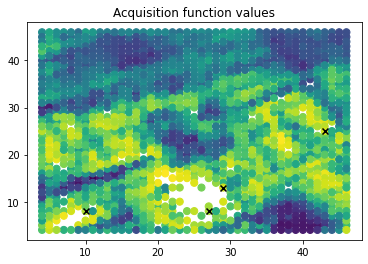

25/25
Epoch 1/500 ... Training loss: 607.0977


/usr/local/lib/python3.7/dist-packages/atomai/models/dklgp/dklgpr.py:129: UserWarning: Replacing a single shared embedding space with 4 independent ones
  warnings.warn(msg)


Epoch 10/500 ... Training loss: 459.9775
Epoch 20/500 ... Training loss: 395.1308
Epoch 30/500 ... Training loss: 347.5056
Epoch 40/500 ... Training loss: 302.3468
Epoch 50/500 ... Training loss: 260.1104
Epoch 60/500 ... Training loss: 214.2312
Epoch 70/500 ... Training loss: 185.0719
Epoch 80/500 ... Training loss: 157.7713
Epoch 90/500 ... Training loss: 136.0757
Epoch 100/500 ... Training loss: 128.9901
Epoch 110/500 ... Training loss: 113.5263
Epoch 120/500 ... Training loss: 103.7142
Epoch 130/500 ... Training loss: 98.3793
Epoch 140/500 ... Training loss: 97.812
Epoch 150/500 ... Training loss: 103.4935
Epoch 160/500 ... Training loss: 105.5593
Epoch 170/500 ... Training loss: 97.1052
Epoch 180/500 ... Training loss: 78.4415
Epoch 190/500 ... Training loss: 74.1023
Epoch 200/500 ... Training loss: 75.6602
Epoch 210/500 ... Training loss: 80.5167
Epoch 220/500 ... Training loss: 68.3103
Epoch 230/500 ... Training loss: 63.1225
Epoch 240/500 ... Training loss: 59.2667
Epoch 250/50

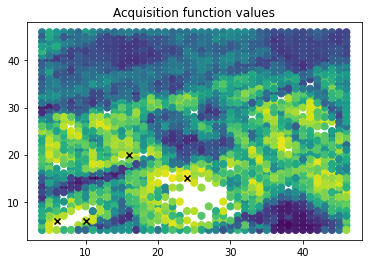

In [11]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=50, c=obj.mean(0))
    for i in range(len(obj)):
        next_point = indices_test[obj[i].argmax()]
        plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 25

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # obtain/update DKL posterior
    dklgp2 = aoi.models.dklGPR(data_dim, embedim=2, precision="single")
    dklgp2.fit_ensemble(X_train, y_train, training_cycles=500, n_models=4)
    # Thompson sampling
    obj, next_point_idx = dklgp2.thompson(X_test)
    # Select next point to "measure"
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points 
    X_train = np.append(X_train, X_test[next_point_idx], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point, 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

Plot results:

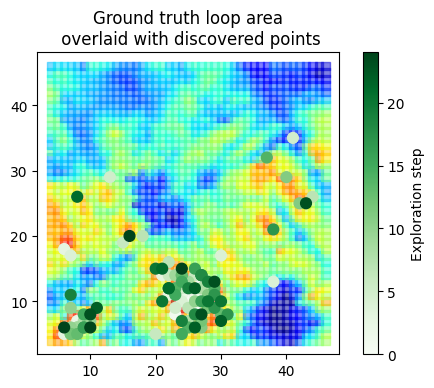

In [15]:
batch_size = 4  # is equal to n_models in the DKL ensemble
seed = 3 # number of initial/seed points (length of X_train before DKL)
_, ax = plt.subplots(dpi=100)
c = np.concatenate([np.array([i]*batch_size) for i in range(len(X_train[seed:])//batch_size)])
ax.scatter(pos_arr[:, 1], pos_arr[:, 0], c=target_area, cmap='jet', alpha=.5, marker='s')
l = ax.scatter(indices_train[seed:, 1], indices_train[seed:, 0], c=c, s=60, cmap="Greens", marker='o')
ax.set_aspect('equal')
ax.set_title("Ground truth loop area\n overlaid with discovered points")
plt.colorbar(l, label="Exploration step")